## Домашнее задание 2

Студент: Киселев Георгий

In [1]:
import os
import gdown
import zipfile
import torch
import torchvision.datasets as datasets
import torchvision.transforms as transforms

from torch import nn
from pathlib import Path
import torch.optim as optim
from torchvision.utils import make_grid

from torch.utils.tensorboard import SummaryWriter
from IPython.display import clear_output
import matplotlib.pyplot as plt
import numpy as np

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Загрузка датасета

In [3]:
os.makedirs('dataset/celeba', exist_ok=True)

if 'img_align_celeba.zip' not in os.listdir():
    url = 'https://drive.google.com/uc?id=0B7EVK8r0v71pZjFTYXZWM3FlRnM'
    output = 'dataset/celeba/img_align_celeba.zip'
    gdown.download(url, output, quiet=False)
else:
    with zipfile.ZipFile('img_align_celeba.zip') as zip:
        zip.extractall('dataset/celeba')

In [4]:
if 'identity_CelebA.txt' in os.listdir():
    os.rename('identity_CelebA.txt', 'dataset/celeba/identity_CelebA.txt')

### Подготовка датасета

Используем загрузчики данных, аналогичные описанным в репозитории

In [5]:
root_path = Path(os.getcwd())
dataset_path = os.path.join(root_path, 'dataset\\celeba')
shape_target = 128

In [6]:
dataset = datasets.ImageFolder(
    root=dataset_path,
    transform=transforms.Compose([
        transforms.Resize(shape_target),
        transforms.CenterCrop(shape_target),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])
)

In [7]:
batch_size = 32
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2)

### Создание модели

#### CSPup блок

В CSPUp-блоке решено использовать ConvTranspose2d как предположительно более эффективный способ преобразования (за счет того, что он обучаем). Архитектура соответствует указанной в задании. Параметр stride отвечает за увеличение размерности и уменьшение количества каналов

Источник: https://discuss.pytorch.org/t/upsample-conv2d-vs-convtranspose2d/138081

In [8]:
class CSPup(nn.Module):

    def __init__(self, n_channels_start=1024, stride=2):

        super(CSPup, self).__init__()
        self.stride = stride
        self.n_channels_start = n_channels_start
        self.n_channels_target = n_channels_start // stride
        
        self.left_upsample = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=self.n_channels_target,
                out_channels=self.n_channels_target,
                kernel_size=4,
                stride=stride,
                padding=1,
                bias=False
            ),
            nn.BatchNorm2d(self.n_channels_target),
            nn.ReLU()
        )

        self.right_upsample = nn.Sequential(
            nn.Conv2d(
                in_channels=self.n_channels_target,
                out_channels=self.n_channels_target,
                kernel_size=1,
                stride=1,
                padding=0,
                bias=False
            ),
            nn.BatchNorm2d(self.n_channels_target),
            nn.ReLU(),
            nn.ConvTranspose2d(
                in_channels=self.n_channels_target,
                out_channels=self.n_channels_target,
                kernel_size=4,
                stride=stride,
                padding=1,
                bias=False
            ),
            nn.BatchNorm2d(self.n_channels_target),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=self.n_channels_target,
                out_channels=self.n_channels_target,
                kernel_size=3,
                stride=1,
                padding=1,
                bias=False
            ),
            nn.BatchNorm2d(self.n_channels_target),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=self.n_channels_target,
                out_channels=self.n_channels_target,
                kernel_size=3,
                stride=1,
                padding=1,
                bias=False
            ),
            nn.BatchNorm2d(self.n_channels_target),
            nn.ReLU()
        )

    def forward(self, x):
        x_left, x_right = torch.chunk(x, 2, dim=1)
        x_left = self.left_upsample(x_left)
        x_right = self.right_upsample(x_right)
        
        return x_left + x_right

Определим класс генератора, для бейслайна используем предложенную архитектуру: 4 блока CSPup (каналы уменьшаются от 1024 до 64, размерность матриц признаков возрастает от 4 до 64). На последнем слое преобразуем с помощью ConvTranspose2d в трехканальное изображение 128 на 128

In [9]:
class Generator(nn.Module):
    def __init__(self, n_channels_start, n_channels_target, stride):
        super(Generator, self).__init__()
        self.first_cspup = CSPup(n_channels_start, stride)
        self.second_cspup = CSPup(n_channels_start // stride, stride)
        self.third_cspup = CSPup(n_channels_start // (stride**2), stride)
        self.fourth_cspup = CSPup(n_channels_start // (stride**3), stride)
        self.last_deconv = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=n_channels_start // (stride**4),
                out_channels=n_channels_target,
                kernel_size=4,
                stride=2,
                padding=1
            ),
            nn.ReLU()
        )

    def forward(self, x):
        x = self.first_cspup(x)
        x = self.second_cspup(x)
        x = self.third_cspup(x)
        x = self.fourth_cspup(x)

        return self.last_deconv(x)

Дискриминатор взят из репозитория (DCGan)

In [10]:
class Discriminator(nn.Module):
    def __init__(self, n_channels_in=3, base_n_features=64):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(

            nn.Conv2d(
                in_channels=n_channels_in,
                out_channels=base_n_features, 
                kernel_size=4,
                stride=2, 
                padding=1,
                bias=False
            ),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(
                in_channels=base_n_features,
                out_channels=base_n_features * 2, 
                kernel_size=4,
                stride=2, 
                padding=1,
                bias=False
            ),
            nn.BatchNorm2d(base_n_features * 2),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(
                in_channels=base_n_features * 2,
                out_channels=base_n_features * 4, 
                kernel_size=4,
                stride=2, 
                padding=1,
                bias=False
            ),
            nn.BatchNorm2d(base_n_features * 4),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(
                in_channels=base_n_features * 4,
                out_channels=base_n_features * 8, 
                kernel_size=4,
                stride=2, 
                padding=1,
                bias=False
            ),
            nn.BatchNorm2d(base_n_features * 8),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(
                in_channels=base_n_features * 8,
                out_channels=base_n_features * 16, 
                kernel_size=4,
                stride=2, 
                padding=1,
                bias=False
            ),
            nn.BatchNorm2d(base_n_features * 16),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(
                in_channels=base_n_features * 16,
                out_channels=1, 
                kernel_size=4,
                stride=1, 
                padding=0,
                bias=False
            )
        )

    def forward(self, input):
        return self.main(input) 

### Обучение

#### Параметры

Начинаем с генерации шума 4x4x1024, в качестве функции потерь и других параметров используем стандартные предложенные значения

In [16]:
n_channels_start = 1024
n_channels_target = 3
shape_start = 4
stride = 2
n_epochs = 5

generator = Generator(n_channels_start, n_channels_target, stride).to(device)
discriminator = Discriminator(n_channels_target).to(device)

In [17]:
criterion = nn.BCEWithLogitsLoss()

fixed_noise = torch.randn(batch_size, n_channels_start, shape_start, shape_start).to(device)

real_label = 1.
fake_label = 0.

lr = 0.0002
beta1 = 0.5

optimizer_gen = optim.Adam(generator.parameters(), lr=lr, betas=(beta1, 0.999))
optimizer_disc = optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, 0.999))

#### Обучение

Дополним предложенный train loop логгированием в tensorboard

In [ ]:
%load_ext tensorboard

# Инициализация TensorBoard
from torch.utils.tensorboard import SummaryWriter
from tensorboard import notebook

writer = SummaryWriter()
notebook.start("--logdir runs")  # Запускаем TensorBoard в ноутбуке

img_list = []    # Список для сохранения сгенерированных изображений
G_losses = []    # Список для сохранения потерь генератора
D_losses = []    # Список для сохранения потерь дискриминатора
iters = 0        # Счетчик итераций

for epoch in range(0, n_epochs):
    for i, data in enumerate(dataloader, 0):
        
        # Обучение дискриминатора
        discriminator.zero_grad()                                 # Обнуляем градиенты D
        real = data[0].to(device)                             # Загружаем батч реальных изображений
        b_size = real.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        output = discriminator(real).view(-1)                  # Прямой проход реальных изображений через D
        errD_real = criterion(output, label)                      # Потери на реальных изображениях
        errD_real.backward()                                      # Обратное распространение
        D_x = output.mean().item()                                # Средний вывод D для реальных изображений

        # Генерация фейковых изображений
        noise = torch.randn(b_size, n_channels_start, shape_start, shape_start, device=device)
        fake = generator(noise)                                   # Генерация фейкового батча
        label.fill_(fake_label)
        output = discriminator(fake.detach()).view(-1)            # Классификация фейкового батча
        errD_fake = criterion(output, label)                      # Потери на фейковых изображениях
        errD_fake.backward()                                      # Обратное распространение
        D_G_z1 = output.mean().item()                             # Средний вывод D для фейков
        errD = errD_real + errD_fake                              # Суммарные потери D
        optimizer_disc.step()                                     # Обновляем веса D

        # Обучение генератора
        generator.zero_grad()                                     # Обнуляем градиенты G
        label.fill_(real_label)                                   # Меняем метки для обучения G
        output = discriminator(fake).view(-1)                     # Повторный проход через обновленный D
        errG = criterion(output, label)                           # Потери генератора
        errG.backward()                                           # Обратное распространение
        D_G_z2 = output.mean().item()                             # Средний вывод D после обновления G
        optimizer_gen.step()                                      # Обновляем веса G

        # Логирование в TensorBoard
        writer.add_scalar('Loss_D', errD.item(), iters)
        writer.add_scalar('Loss_G', errG.item(), iters)
        writer.add_scalar('D(x)', D_x, iters)
        writer.add_scalar('D(G(z))', D_G_z1, iters)
        writer.flush()  # Для live-обновления TensorBoard

        # Выводим статистику обучения
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, n_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Визуализация сгенерированных изображений каждые 200 итераций
        if (iters % 200 == 0) or ((epoch == n_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = generator(fixed_noise).detach().cpu()
                img_grid = make_grid(fake, padding=2, normalize=True)
                writer.add_image('Generated_images', img_grid, iters)
                display.clear_output(wait=True)  # Очищаем вывод для live-отображения
                display.display(plt.gcf())      # Показываем изображение
                writer.flush()

        iters += 1
        if i == 2000:
            break

writer.close()

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
[0/5][0/6332]	Loss_D: 1.4181	Loss_G: 9.2833	D(x): 0.2333	D(G(z)): 0.2346 / -9.2832
[0/5][50/6332]	Loss_D: 0.1095	Loss_G: 12.7851	D(x): 5.5266	D(G(z)): -12.6059 / -12.7851
[0/5][100/6332]	Loss_D: 0.0089	Loss_G: 8.9218	D(x): 7.8259	D(G(z)): -8.6973 / -8.9217
[0/5][150/6332]	Loss_D: 0.0037	Loss_G: 6.9857	D(x): 9.1625	D(G(z)): -5.7506 / -6.9848
[0/5][200/6332]	Loss_D: 0.0104	Loss_G: 7.4453	D(x): 9.1301	D(G(z)): -6.8389 / -7.4447
[0/5][250/6332]	Loss_D: 0.0015	Loss_G: 7.1223	D(x): 11.1297	D(G(z)): -6.6085 / -7.1215
[0/5][300/6332]	Loss_D: 0.0014	Loss_G: 7.9607	D(x): 9.1895	D(G(z)): -7.6535 / -7.9604
[0/5][350/6332]	Loss_D: 0.0006	Loss_G: 8.0666	D(x): 11.0438	D(G(z)): -7.5644 / -8.0662
[0/5][400/6332]	Loss_D: 0.0002	Loss_G: 10.2876	D(x): 12.5024	D(G(z)): -9.0888 / -10.2875
[0/5][450/6332]	Loss_D: 0.0051	Loss_G: 7.6535	D(x): 11.5175	D(G(z)): -7.4029 / -7.6530


KeyboardInterrupt: 

#### Изображения генератора

Сначала распечатаем последний батч сгенерированных изображений

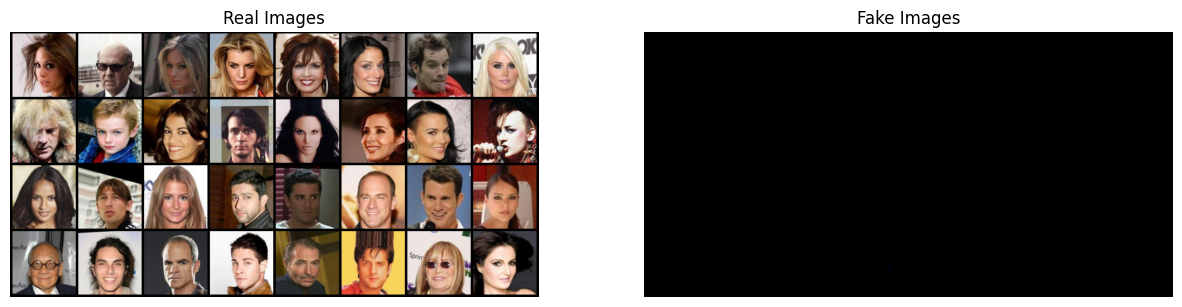

In [ ]:
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).to(device),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()